# Use Neural Network to Approximate Runge Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
import random
import pandas as pd

## Define Runge Function

In [2]:
f = lambda x: 1 / (1+25*x**2)

## Produce Data

We produce 1024 samples in training set and 256 samples in validation set.

```.unsqueeze(1)``` is to convert the size to a $n\times 1$ matrix.

In [3]:
n_train, n_val = 1024, 256
Xtr = torch.linspace(-1, 1, n_train).unsqueeze(1)
ytr = f(Xtr)
Xva = torch.linspace(-1, 1, n_val).unsqueeze(1)
yva = f(Xva)

## Define Model
Here, we set the neural network to be 3 layers including 1 input layer, 1 hidden layer and 1 output layer, each has 16 neurons except the output layer.

$\tanh(x)$ function is chosen to be the activation function.

Also, we use Adam optimizer to modify learning rate as the changing of gradient.

In [4]:
seed = 114514
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model = nn.Sequential(nn.Linear(1, 16), nn.Tanh(), nn.Linear(16, 16), nn.Tanh(), nn.Linear(16, 1))

mse = nn.MSELoss() # Define MSE loss function
opt = optim.Adam(model.parameters(), lr=3e-3) # optimizer


## Training & Validation
We train for 2000 times, each time we do:
* ```opt.zero_grad()``` to rest the gradient
* ```mse(model(Xtr), ytr)``` to calculate the MSE loss of training set
* ```loss.backward()``` to calculate the gradient
* ```opt.step()``` to update the parameters according to the gradient
* Next, calculte the MSE loss of validation set without updating parameters
* Save the losses to plot

In [5]:
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    # training step
    opt.zero_grad()
    loss = mse(model(Xtr), ytr)
    loss.backward()
    opt.step()

    # validation step
    with torch.no_grad():
        val_loss = mse(model(Xva), yva).item()
    
    train_losses.append(loss.item())
    val_losses.append(val_loss)

## Graphing

MAX error = 0.004171
RMSE      = 0.001666


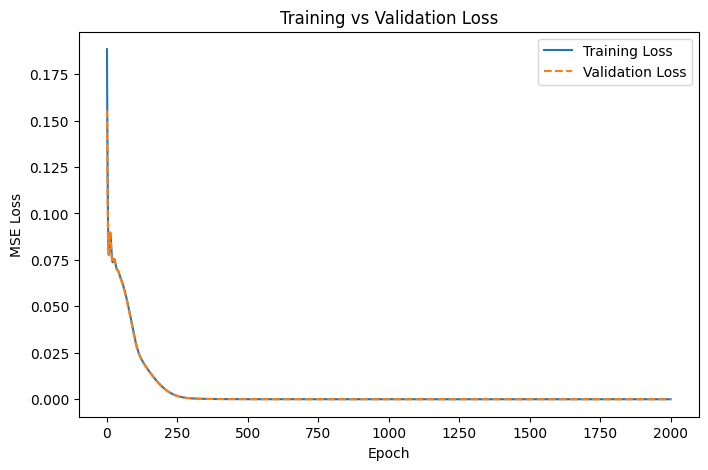

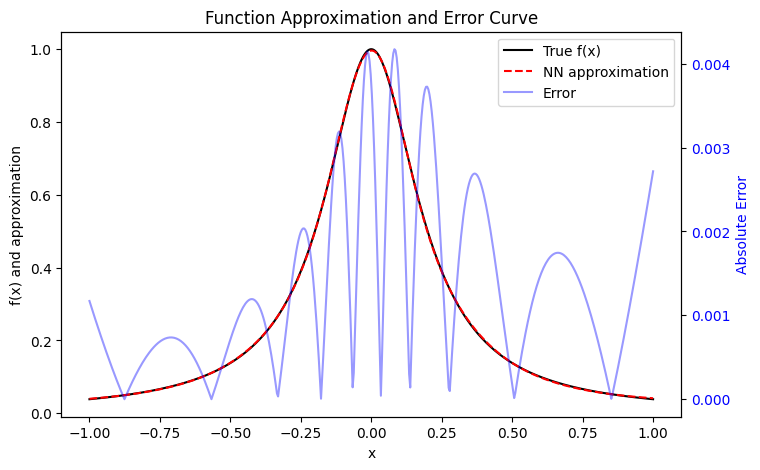

In [6]:
# ---- Training/Validation loss ----
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# ---- Function approximation and Error curve ----
X_test = torch.linspace(-1, 1, 500).unsqueeze(1)
with torch.no_grad():
    y_pred = model(X_test)        # NN approximation
y_true = f(X_test)  # True function
error = torch.abs(y_true - y_pred)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.numpy(), y_true.numpy(), color="black", label="True f(x)")
ax1.plot(X_test.numpy(), y_pred.numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f(x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.numpy(), error.numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("Function Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")

# Comparison

## Different number of neurons
We test different number of 2, 4, 8, 16, 32, 64 and 128 neurons. At first, when learning rate = 0.003, RMSE at 128 neurons are higher than at 64 neurons. It is possible that the learning rate is too high for 128 neurons, therefore when learning rate is modified to 0.0003, we see the RMSE at 128 neurons is lower than that of 64 neurons successfully.

In [11]:
seed = 114514
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

n_train, n_val = 1024, 256
Xtr = torch.linspace(-1, 1, n_train).unsqueeze(1)
ytr = f(Xtr)
Xva = torch.linspace(-1, 1, n_val).unsqueeze(1)
yva = f(Xva)

def compare_hidden_sizes(hidden_sizes=[4, 8, 16, 32, 64], epochs=2000, lr=3e-3):
    results = []

    plt.figure(figsize=(9,6))
    plt.plot(X_test.numpy(), y_true.numpy(), label="True f(x)", color="black", linewidth=2)

    for h in hidden_sizes:
        model = nn.Sequential(nn.Linear(1, h), nn.Tanh(), nn.Linear(h, h), nn.Tanh(), nn.Linear(h, 1))
        mse = nn.MSELoss()
        opt = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            opt.zero_grad()
            loss = mse(model(Xtr), ytr)
            loss.backward()
            opt.step()

        with torch.no_grad():
            y_pred = model(X_test)
            rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
            sup_error = torch.abs(y_true - y_pred).max().item()

        plt.plot(X_test.numpy(), y_pred.numpy(), linestyle="--", label=f"hidden={h}")

        results.append({"hidden_size": h, "RMSE": rmse, "Max error": sup_error})

    plt.title("Approximation of Runge function with Different Hidden Sizes")
    plt.legend()
    plt.show()

    plt.plot([r["hidden_size"] for r in results], [r["RMSE"] for r in results], marker='o')
    plt.legend()
    plt.title("RMSE vs Hidden Size")
    plt.xticks(hidden_sizes, rotation=45)
    plt.show()

    df = pd.DataFrame(results)
    print(df)
    return df

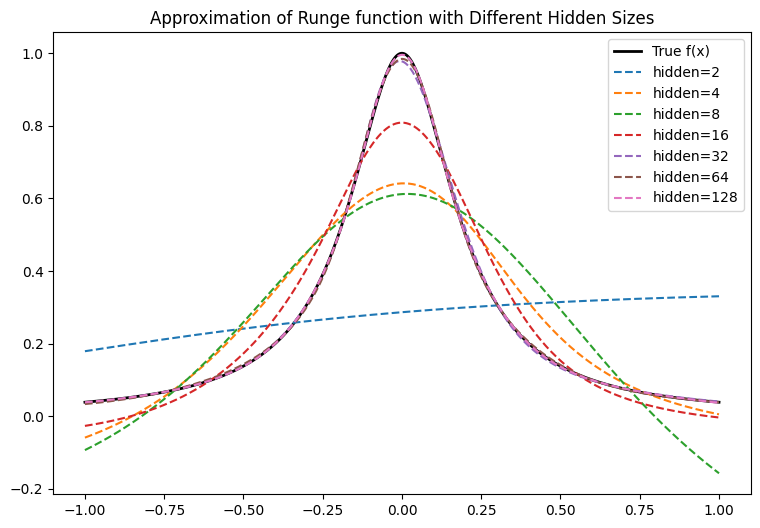

/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_6765/3348069330.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


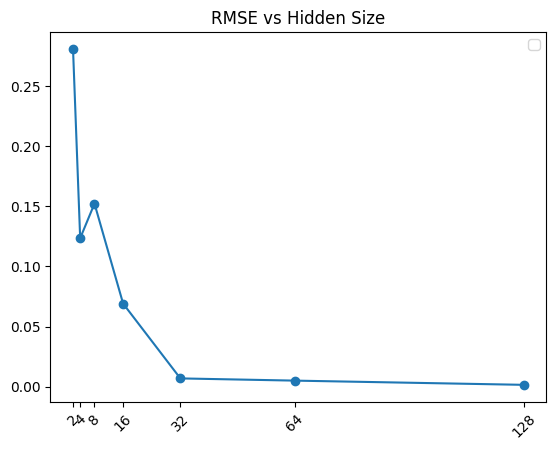

   hidden_size      RMSE  Max error
0            2  0.280884   0.713557
1            4  0.123385   0.358499
2            8  0.152189   0.388129
3           16  0.069027   0.191126
4           32  0.006839   0.024986
5           64  0.004994   0.015619
6          128  0.001489   0.004313


In [12]:
df = compare_hidden_sizes([2**n for n in range(1, 8)], lr=3e-4)

## Different Activation Function
We compare the different activation function (tanh and sigmoid). We can discover that error is larger when using sigmoid function. The reason is probably that tanh is symmetric in [-1,1] with respect to (0,0).

In [9]:
def compare_tanh_sigmoid(hidden_size=32, epochs=2000, lr=3e-3):
    seed = 114514
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    n_train, n_val = 1024, 256
    Xtr = torch.linspace(-1, 1, n_train).unsqueeze(1)
    ytr = f(Xtr)
    Xva = torch.linspace(-1, 1, n_val).unsqueeze(1)
    yva = f(Xva)
    
    activations = {"tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}
    results = {}

    # 訓練並記錄每個模型
    for name, act in activations.items():
        model = nn.Sequential(
            nn.Linear(1, hidden_size), act,
            nn.Linear(hidden_size, hidden_size), act,
            nn.Linear(hidden_size, 1)
        )
        mse = nn.MSELoss()
        opt = optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []
        for epoch in range(epochs):
            opt.zero_grad()
            loss = mse(model(Xtr), ytr)
            loss.backward()
            opt.step()

            with torch.no_grad():
                val_loss = mse(model(Xva), yva).item()

            train_losses.append(loss.item())
            val_losses.append(val_loss)

        with torch.no_grad():
            y_pred = model(X_test)
            error = torch.abs(y_true - y_pred)
            rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
            sup_error = error.max().item()

        results[name] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "y_pred": y_pred,
            "error": error,
            "rmse": rmse,
            "sup_error": sup_error,
        }

    # --- 圖 1: Loss 曲線 ---
    plt.figure(figsize=(7,5))
    plt.plot(results["tanh"]["train_losses"], label="Tanh - Train", color="red")
    plt.plot(results["tanh"]["val_losses"], label="Tanh - Val", color="red", linestyle="--")
    plt.plot(results["sigmoid"]["train_losses"], label="Sigmoid - Train", color="green")
    plt.plot(results["sigmoid"]["val_losses"], label="Sigmoid - Val", color="green", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training vs Validation Loss (Tanh vs Sigmoid)")
    plt.legend()
    plt.show()

    # --- 圖 2: 函數近似 ---
    plt.figure(figsize=(7,5))
    plt.plot(X_test.numpy(), y_true.numpy(), color="black", label="True f(x)", linewidth=2)
    plt.plot(X_test.numpy(), results["tanh"]["y_pred"].numpy(), color="red", linestyle="--", label="Tanh")
    plt.plot(X_test.numpy(), results["sigmoid"]["y_pred"].numpy(), color="green", linestyle="--", label="Sigmoid")
    plt.legend()
    plt.title("Function Approximation (Tanh vs Sigmoid)")
    plt.show()

    # --- 圖 3: 誤差曲線 ---
    plt.figure(figsize=(7,4))
    plt.plot(X_test.numpy(), results["tanh"]["error"].numpy(), color="red", label="Tanh Error")
    plt.plot(X_test.numpy(), results["sigmoid"]["error"].numpy(), color="green", label="Sigmoid Error")
    plt.title("Absolute Error (Tanh vs Sigmoid)")
    plt.xlabel("x")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

    # --- 印數據 ---
    for name in activations.keys():
        print(f"{name.upper()} (hidden={hidden_size}, epochs={epochs})")
        print(f"  RMSE      = {results[name]['rmse']:.6f}")
        print(f"  Max error = {results[name]['sup_error']:.6f}")
        print("-"*40)

    return results


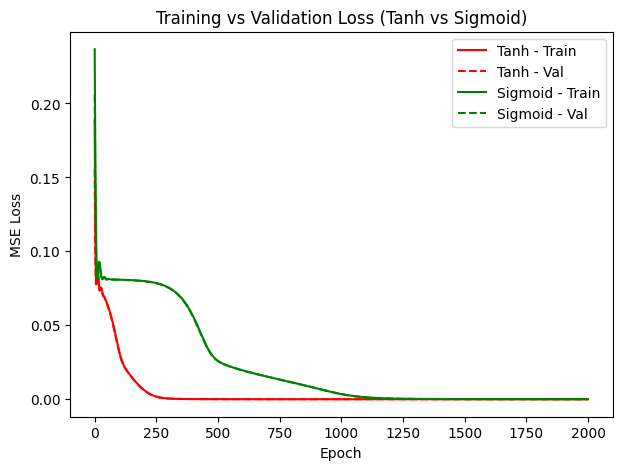

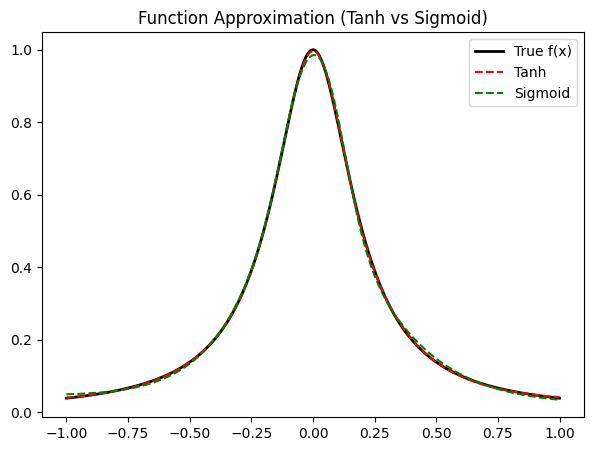

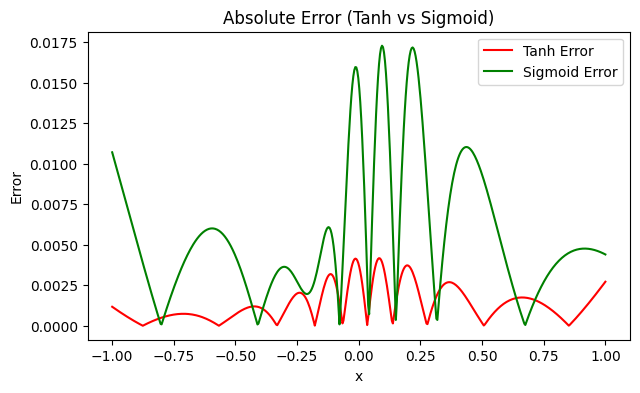

TANH (hidden=16, epochs=2000)
  RMSE      = 0.001666
  Max error = 0.004171
----------------------------------------
SIGMOID (hidden=16, epochs=2000)
  RMSE      = 0.006988
  Max error = 0.017289
----------------------------------------


In [10]:
results = compare_tanh_sigmoid(hidden_size=16, epochs=2000)
